In [1]:
%pip install -r requirements.txt
%pip install tqdm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   -------- ------------------------------- 0.3/1.3 MB ? eta -:--:--
   ------------------------ --------------- 0.8/1.3 MB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 3.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.9 MB ? eta -:--:--
   - -------------------------------------- 0.8/15.9 MB 4.8 MB/s eta 0:00:04
   --- ------------------------------------ 1.6/15.9 MB 3.8 MB/s eta 0:00:04
   ------ --------------------------------- 2.6/15.9 MB 4.6 MB/s eta 0:00:03
   --------- ------------------------------ 3.9/15.9 MB 4.9 MB/s eta 0:00:03
   ------------- -------------------------- 5.2/15.9 MB 5.1 MB/s eta 0:00:03
   ---------------- ----------------------- 6.6/15.9 MB 5.4 MB/s eta 0:00:02
   -------------------- ------------------- 8.1/15.9 MB 5.7 MB/s eta 0:00:02
   ----------------------- -

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.18.0 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import json
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [3]:
from torch.utils.data import Dataset, DataLoader, random_split

In [4]:
def load_image_paths(base_path):
    """
    Load all image paths from the dataset.

    Args:
        base_path (str): The root directory where the images are stored.
    
    Returns:
        dict: A dictionary where each key is a person's directory, and the value is a list of image paths for that person.
    """
    image_paths = {}
    
    # Loop through each directory (person)
    for person_dir in os.listdir(base_path):
        person_path = os.path.join(base_path, person_dir)
        
        if os.path.isdir(person_path):
            # Get all image files in the directory
            images = [os.path.join(person_path, img) for img in os.listdir(person_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            if images:  # If the person has images
                image_paths[person_dir] = images
    
    return image_paths

In [5]:
load_image_paths("faces-data")

{'0': ['faces-data\\0\\0.jpg',
  'faces-data\\0\\1.jpg',
  'faces-data\\0\\2.jpg',
  'faces-data\\0\\3.jpg'],
 '1': ['faces-data\\1\\0.jpg', 'faces-data\\1\\1.jpg'],
 '10': ['faces-data\\10\\0.jpg',
  'faces-data\\10\\1.jpg',
  'faces-data\\10\\2.jpg',
  'faces-data\\10\\3.jpg'],
 '1000': ['faces-data\\1000\\0.jpg', 'faces-data\\1000\\1.jpg'],
 '100000': ['faces-data\\100000\\0.png',
  'faces-data\\100000\\1.png',
  'faces-data\\100000\\2.png',
  'faces-data\\100000\\3.png',
  'faces-data\\100000\\4.png'],
 '100001': ['faces-data\\100001\\0.png',
  'faces-data\\100001\\1.png',
  'faces-data\\100001\\2.png',
  'faces-data\\100001\\3.png',
  'faces-data\\100001\\4.png'],
 '100002': ['faces-data\\100002\\0.png',
  'faces-data\\100002\\1.png',
  'faces-data\\100002\\2.png',
  'faces-data\\100002\\3.png',
  'faces-data\\100002\\4.png'],
 '100003': ['faces-data\\100003\\0.png',
  'faces-data\\100003\\1.png',
  'faces-data\\100003\\2.png',
  'faces-data\\100003\\3.png',
  'faces-data\\100003\

In [6]:
def save_progress(progress_file, progress_data):
    """
    Save the current progress of pair generation to a JSON file.
    
    Args:
        progress_file (str): The file path to save the progress data.
        progress_data (dict): The dictionary containing the current progress data.
        
    Description:
        This function writes the progress (number of positive and negative pairs generated)
        to a file in JSON format. This helps in resuming the generation process from where
        it left off in case of a notebook restart.
    """
    with open(progress_file, 'w') as f:
        json.dump(progress_data, f)

In [7]:
def load_progress(progress_file):
    """
    Load the progress information from a file.
    
    Args:
        progress_file (str): The file path to load progress from.
    
    Returns:
        dict: Dictionary containing the current progress data, or None if no progress file exists.
        
    Description:
        This function reads the progress information from a JSON file and returns it. 
        If the file does not exist, it returns None, indicating no saved progress.
    """
    if os.path.exists(progress_file):
        with open(progress_file, 'r') as f:
            return json.load(f)
    return None

In [8]:
def save_pairs_to_disk(pairs, file_path):
    """
    Save the generated image pairs to a disk using pickle.
    
    Args:
        pairs (list): The list of image pairs (either positive or negative) to save.
        file_path (str): The file path to save the pairs (pickle file).
        
    Description:
        This function serializes the pairs using pickle and saves them to a file. This 
        allows us to store large amounts of data (pairs) efficiently, which can be loaded 
        later if needed.
    """
    with open(file_path, 'wb') as f:
        pickle.dump(pairs, f)

In [9]:
def generate_positive_pairs(image_paths, batch_size):
    """
    Generate positive pairs (same person) from the dataset.
    
    Args:
        image_paths (dict): A dictionary where each directory (person) is mapped to a list of image paths.
        batch_size (int): The number of positive pairs to generate in the current batch.
    
    Returns:
        list: A list of positive pairs (tuples of image paths).
        
    Description:
        This function generates positive pairs by randomly selecting a person and then 
        selecting two distinct images of that person. It continues until the specified 
        batch size of positive pairs is reached.
    """
    positive_pairs = []
    directories = list(image_paths.keys())

    while len(positive_pairs) < batch_size:
        person = random.choice(directories)
        images = image_paths[person]

        # Ensure distinct pairs by using different image indices
        for i in range(len(images)):
            for j in range(i + 1, len(images)):  # i != j to create distinct pairs
                positive_pairs.append((images[i], images[j]))
                if len(positive_pairs) >= batch_size:
                    break
            if len(positive_pairs) >= batch_size:
                break

    return positive_pairs

In [10]:
def generate_negative_pairs(image_paths, batch_size):
    """
    Generate negative pairs (different people) from the dataset, ensuring no duplicate pairs.
    
    Args:
        image_paths (dict): A dictionary where each directory (person) is mapped to a list of image paths.
        batch_size (int): The number of negative pairs to generate in the current batch.
    
    Returns:
        list: A list of negative pairs (tuples of image paths).
        
    Description:
        This function generates negative pairs by randomly selecting two different people 
        and pairing one image from each. It ensures no duplicate pairs are generated.
    """
    negative_pairs = set()  # Use a set to track unique pairs
    directories = list(image_paths.keys())

    while len(negative_pairs) < batch_size:
        # Select two directories (people)
        person1, person2 = random.sample(directories, 2)

        # If both people are the same, skip to the next iteration
        if person1 == person2:
            continue

        # Select random images from each person
        image1 = random.choice(image_paths[person1])
        image2 = random.choice(image_paths[person2])

        # Create a unique identifier for the negative pair
        pair = tuple(sorted([image1, image2]))  # Sorting ensures (image1, image2) and (image2, image1) are the same

        # Only add the pair if it's not already in the set
        if pair not in negative_pairs:
            negative_pairs.add(pair)

    # Convert the set of pairs back to a list for returning
    return list(negative_pairs)


In [11]:
def generate_pairs_in_batches(image_paths, target_positive_pairs, target_negative_pairs,batch_size, progress_file,positive_file, negative_file):
    """
    Generate positive and negative image pairs in batches and save them after each batch.
    
    Args:
        image_paths (dict): A dictionary where each directory (person) is mapped to a list of image paths.
        target_positive_pairs (int): The total number of positive pairs to generate.
        target_negative_pairs (int): The total number of negative pairs to generate.
        batch_size (int): The number of pairs to generate per batch.
        progress_file (str): The file path to save/load progress.
        positive_file (str): The file path to save/load positive pairs.
        negative_file (str): The file path to save/load negative pairs.
    
    Returns:
        tuple: The total number of positive and negative pairs generated.
        
    Description:
        This function coordinates the generation of positive and negative pairs in batches.
        It loads any saved progress and continues from where it left off. It generates pairs 
        in batches, saves them to disk, and updates the progress after each batch.
    """
    # Load progress if it exists
    progress = load_progress(progress_file)
    if progress:
        positive_count = progress['positive_count']
        negative_count = progress['negative_count']
    else:
        positive_count = 0
        negative_count = 0

    # Load previously saved pairs or initialize empty lists
    if os.path.exists(positive_file):
        with open(positive_file, 'rb') as f:
            positive_pairs = pickle.load(f)
    else:
        positive_pairs = []

    if os.path.exists(negative_file):
        with open(negative_file, 'rb') as f:
            negative_pairs = pickle.load(f)
    else:
        negative_pairs = []

    # Generate pairs in batches until the target count is reached
    while positive_count < target_positive_pairs or negative_count < target_negative_pairs:
        # Generate a batch of positive and negative pairs
        batch_positive_pairs = generate_positive_pairs(image_paths, batch_size)
        batch_negative_pairs = generate_negative_pairs(image_paths, batch_size)

        # Update the count of generated pairs
        positive_count += len(batch_positive_pairs)
        negative_count += len(batch_negative_pairs)

        # Add the generated pairs to the main list
        positive_pairs.extend(batch_positive_pairs)
        negative_pairs.extend(batch_negative_pairs)

        # Save the updated pairs to disk after each batch
        save_pairs_to_disk(positive_pairs, positive_file)
        save_pairs_to_disk(negative_pairs, negative_file)

        # Save progress after each batch
        progress_data = {
            'positive_count': positive_count,
            'negative_count': negative_count
        }
        save_progress(progress_file, progress_data)

        # Stop when the target number of pairs is reached
        if positive_count >= target_positive_pairs and negative_count >= target_negative_pairs:
            break

    return positive_count, negative_count


In [12]:
# Load image paths from the dataset
base_path = 'faces-data'  # Replace with your dataset path
image_paths = load_image_paths(base_path)

# Define the target number of pairs
target_positive_pairs = 10000
target_negative_pairs = 10000
batch_size = 1000  # Number of pairs to generate per batch

# File paths
progress_file = 'faces/working/progress_10k.json'
positive_file = 'faces/working/positive_pairs_10k.pkl'
negative_file = 'faces/working/negative_pairs_10k.pkl'

# Check if pickle files already exist
if os.path.exists(positive_file) or os.path.exists(negative_file):
    print(f"Pairs already generated !! . Exited")
    
else:
    # Generate pairs in batches
    positive_count, negative_count = generate_pairs_in_batches(
        image_paths, 
        target_positive_pairs, 
        target_negative_pairs, 
        batch_size=batch_size,
        progress_file=progress_file,
        positive_file=positive_file,
        negative_file=negative_file
    )

    # Output the number of pairs generated
    print(f"Total positive pairs generated: {positive_count}")
    print(f"Total negative pairs generated: {negative_count}")

Pairs already generated !! . Exited


# visualization

In [13]:
def load_pairs_from_pickle(pickle_file_path):
    """
    Load pairs of images from a pickle file.
    
    Args:
        pickle_file_path (str): Path to the pickle file containing pairs.
        
    Returns:
        list: A list of pairs, where each pair is a tuple of two image file paths.
    """
    with open(pickle_file_path, 'rb') as file:
        pairs = pickle.load(file)
    return pairs

In [14]:
def get_random_pair(pairs):
    """
    Randomly select a pair from the list of pairs.
    
    Args:
        pairs (list): List of pairs, where each pair is a tuple of two image file paths.
        
    Returns:
        tuple: A randomly selected pair of image paths.
    """
    return random.choice(pairs)

In [15]:
def visualize_pair(pair, is_negative=False):
    """
    Visualize a single pair of images along with their directory and image names as labels on the images.
    The label format will differ based on whether the pair is positive or negative.

    Args:
        pair (tuple): A tuple containing two image paths.
        is_negative (bool): A flag indicating whether the pair is negative. Default is False (positive pair).
    """
    # Load images
    image1 = Image.open(pair[0])
    image2 = Image.open(pair[1])

    # Extract directory and image names
    dir1, filename1 = os.path.split(pair[0])
    dir2, filename2 = os.path.split(pair[1])

    # Display the images with directory/image name as labels
    plt.figure(figsize=(8, 4))
    
    # Image 1
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.title(f"Image 1")
    # Label with directory and image name
    label1 = f"{os.path.basename(dir1)}/{filename1}"
    plt.text(0, 10, label1, color='white', fontsize=8, ha='left', va='top', bbox=dict(facecolor='black', alpha=0.7))
    plt.axis('off')

    # Image 2
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.title(f"Image 2")
    # Label with directory and image name
    label2 = f"{os.path.basename(dir2)}/{filename2}"
    plt.text(0, 10, label2, color='white', fontsize=8, ha='left', va='top', bbox=dict(facecolor='black', alpha=0.7))
    plt.axis('off')

    # Add title for positive or negative pair
    if is_negative:
        plt.suptitle("Negative Pair", fontsize=16, color='red', y=0.95)
    else:
        plt.suptitle("Positive Pair", fontsize=16, color='green', y=0.95)

    plt.show()

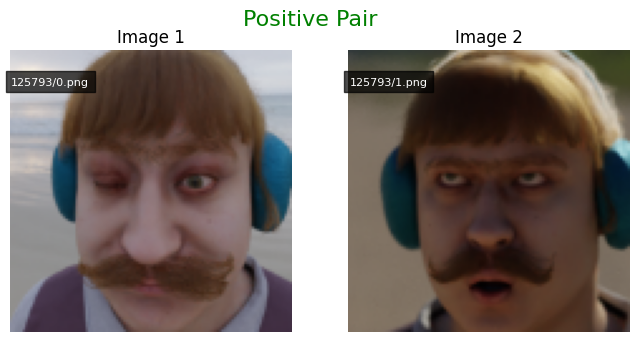

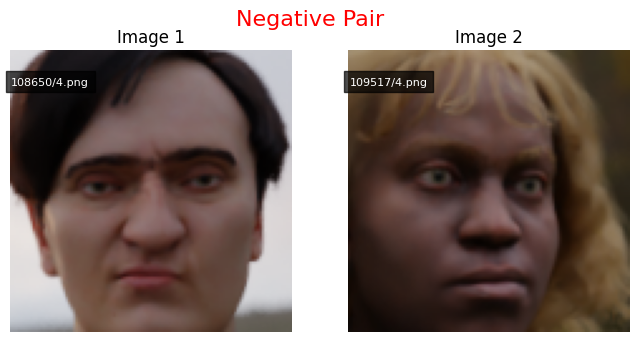

In [16]:
# Define paths to pickle files
positive_pickle = 'faces/working/positive_pairs_10k.pkl'  # Path to positive pairs pickle file
negative_pickle = 'faces/working/negative_pairs_10k.pkl'  # Path to negative pairs pickle file

# Load pairs from pickle files
positive_pairs = load_pairs_from_pickle(positive_pickle)
negative_pairs = load_pairs_from_pickle(negative_pickle)

# Randomly select a pair from positive pairs
random_positive_pair = get_random_pair(positive_pairs)
visualize_pair(random_positive_pair, is_negative=False)

# Randomly select a pair from negative pairs
random_negative_pair = get_random_pair(negative_pairs)
visualize_pair(random_negative_pair, is_negative=True)


# validation

In [17]:
def validate_pair(pair_type, pair):
    """
    Validate the given pair based on its type.
    Positive pairs should belong to the same directory.
    Negative pairs should belong to different directories.
    
    Args:
        pair_type (str): Type of pair ('positive' or 'negative').
        pair (tuple): The pair to be validated, containing image paths.
    
    Returns:
        bool: True if the pair is valid, False otherwise.
    """
    # Extract image paths from the pair
    image_path_1, image_path_2 = pair

    # Extract the directory (person) name from the image paths
    dir_1 = os.path.basename(os.path.dirname(image_path_1))
    dir_2 = os.path.basename(os.path.dirname(image_path_2))

    if pair_type == 'positive':
        # Positive pair: Check if both images belong to the same directory
        if dir_1 == dir_2:
            return True
        else:
            print(f"Validation failed for positive pair: {pair}")
            return False
    elif pair_type == 'negative':
        # Negative pair: Check if the images belong to different directories
        if dir_1 != dir_2:
            print(f"Valid negative pair: {pair}")
            return True
        else:
            print(f"Validation failed for negative pair: {pair}")
            return False
    else:
        print(f"Unknown pair type: {pair_type}")
        return False

In [18]:
def load_progress(progress_file):
    """
    Load progress data from a JSON file. If the file does not exist or is empty,
    initialize it with default values.
    
    Args:
        progress_file (str): Path to the progress JSON file.
    
    Returns:
        dict: The progress data, or None if the file does not exist and cannot be initialized.
    """
    if not os.path.exists(progress_file) or os.path.getsize(progress_file) == 0:
        # If the file doesn't exist or is empty, initialize with default values
        print(f"File {progress_file} is empty or does not exist. Initializing with default values.")
        
        # Initialize default progress values
        progress_data = {
            'positive_index': 0,
            'negative_index': 0
        }
        
        # Write the default data to the file
        with open(progress_file, 'w') as f:
            json.dump(progress_data, f)
        
        return progress_data  # Return the initialized progress data
    
    # If the file exists and is not empty, load and return the data
    with open(progress_file, 'r') as f:
        return json.load(f)


def save_progress(progress_file, progress_data):
    """
    Save the validation progress to a JSON file.
    
    Args:
        progress_file (str): The path to the progress file.
        progress_data (dict): The progress data to save.
    
    Returns:
        None
    """
    with open(progress_file, 'w') as f:
        json.dump(progress_data, f)


In [19]:
def load_pairs_from_pickle(pickle_file):
    """
    Load pairs from a pickle file.
    
    Args:
        pickle_file (str): The path to the pickle file containing the pairs.
    
    Returns:
        list: A list of pairs.
    """
    if os.path.exists(pickle_file):
        with open(pickle_file, 'rb') as f:
            return pickle.load(f)
    return []


In [20]:
def validate_all_pairs(positive_file, negative_file, validated_positive_file, validated_negative_file, progress_file):
    """
    Validate all pairs in both positive and negative pickle files without visualization.
    The user will be asked to confirm whether each pair is valid or invalid.
    
    Args:
        positive_file (str): The path to the pickle file containing positive pairs.
        negative_file (str): The path to the pickle file containing negative pairs.
        validated_positive_file (str): The file path to save validated positive pairs.
        validated_negative_file (str): The file path to save validated negative pairs.
        progress_file (str): The file to save/load the progress of validation.
    
    Returns:
        None
    """
    # Load pairs from pickle files
    positive_pairs = load_pairs_from_pickle(positive_file)
    negative_pairs = load_pairs_from_pickle(negative_file)

    # Initialize validated pairs
    validated_positive_pairs = []
    validated_negative_pairs = []

    # Process progress (to avoid re-checking already validated pairs)
    progress = load_progress(progress_file)
    if progress:
        positive_count = progress['positive_count']
        negative_count = progress['negative_count']
    else:
        positive_count = 0
        negative_count = 0

    validation_success = True  # Flag to track overall validation status

    # Validate positive pairs
    for i, pair in enumerate(positive_pairs[positive_count:], start=positive_count):
        print(f"Validating Positive Pair {i+1}/{len(positive_pairs)}")
        is_valid = validate_pair('positive', pair)
        if is_valid:
            print(f"Valid positive pair: {pair}")
            validated_positive_pairs.append(pair)
        else:
            print(f"Invalid positive pair: {pair}")
            validation_success = False  # Set the flag to False if any pair is invalid

        # Save progress after each validation
        progress_data = {
            'positive_count': i + 1,
            'negative_count': negative_count
        }
        save_progress(progress_file, progress_data)

    # Validate negative pairs
    for i, pair in enumerate(negative_pairs[negative_count:], start=negative_count):
        print(f"Validating Negative Pair {i+1}/{len(negative_pairs)}")
        is_valid = validate_pair('negative', pair)
        if is_valid:
            print(f"Valid negative pair: {pair}")
            validated_negative_pairs.append(pair)
        else:
            print(f"Invalid negative pair: {pair}")
            validation_success = False  # Set the flag to False if any pair is invalid

        # Save progress after each validation
        progress_data = {
            'positive_count': len(positive_pairs),
            'negative_count': i + 1
        }
        save_progress(progress_file, progress_data)

    # Save validated pairs back to pickle files if validation was successful
    if validation_success:
        with open(validated_positive_file, 'wb') as f:
            pickle.dump(validated_positive_pairs, f)

        with open(validated_negative_file, 'wb') as f:
            pickle.dump(validated_negative_pairs, f)

        print("Validation complete!")
    else:
        print("Validation failed! Some pairs were marked as invalid.")

In [21]:
# Define the file paths
positive_file = 'faces/working/positive_pairs_10k.pkl'
negative_file = 'faces/working/negative_pairs_10k.pkl'
validated_positive_file = 'faces/working/validated_negative_pairs_10k.pkl'  # Path to save validated positive pairs
validated_negative_file = 'faces/working/validated_positive_pairs_10k.pkl'  # Path to save validated negative pairs
progress_file = 'faces/working/progress_10k.json'  # Path to save/load validation progress

# Run the validation check on all pairs
validate_all_pairs(positive_file, negative_file, validated_positive_file, validated_negative_file, progress_file)

Validation complete!


# Making dataset

In [22]:
def preprocess_image(file_path):
    """
    Preprocess a single image: load, decode, resize, and apply Gaussian normalization.
    
    Args:
        file_path (str): Path to the image file.
        
    Returns:
        torch.Tensor: Preprocessed image tensor with Gaussian normalization.
    """
    # Define mean and std for Gaussian normalization (ImageNet values as an example)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Transformation pipeline with Gaussian normalization
    transform = transforms.Compose([
        transforms.Resize((112, 112)),
        transforms.ToTensor(), # Converts image to tensor with [0,1] range automatically
        transforms.Normalize(mean=mean, std=std), # Gaussian normalization
    ])

    # Load and preprocess the image
    img = Image.open(file_path).convert('RGB')
    img_tensor = transform(img)

    return img_tensor

In [23]:
def preprocess_pairs(pairs, label):
    """
    Preprocess pairs of images and assign labels.
    
    Args:
        pairs (list of tuples): List of (img1_path, img2_path) pairs.
        label (int): Label for the pairs (1 for positive, 0 for negative).
    
    Returns:
        tuple: Arrays of preprocessed image1, image2, and corresponding labels.
    """
    preprocessed_images_1 = []
    preprocessed_images_2 = []
    labels = []
    
    for img1_path, img2_path in pairs:
        img1 = preprocess_image(img1_path)  # Preprocess the first image
        img2 = preprocess_image(img2_path)  # Preprocess the second image
        preprocessed_images_1.append(img1)
        preprocessed_images_2.append(img2)
        labels.append(label)  # Append the label (scalar value 1 or 0)
    
    # Ensure labels are a 1D NumPy array
    labels = np.array(labels, dtype=np.int32)  # Explicitly set dtype to int32
    
    # Return processed images and labels
    return np.array(preprocessed_images_1), np.array(preprocessed_images_2), labels


In [24]:
def load_pairs(positive_file, negative_file, size):
    """
    Load positive and negative image pairs from pickle files.
    
    Args:
        positive_file (str): Path to the pickle file for positive pairs.
        negative_file (str): Path to the pickle file for negative pairs.
        size (int): Number of pairs to load.
    
    Returns:
        tuple: Positive and negative pairs loaded from files.
    """
    with open(positive_file, "rb") as f:
        positive_pairs = pickle.load(f)
    with open(negative_file, "rb") as f:
        negative_pairs = pickle.load(f)
    return positive_pairs[:size], negative_pairs[:size]


In [25]:
class FacePairsDataset(Dataset):
    def __init__(self, img1, img2, labels):
        self.img1 = img1
        self.img2 = img2
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.img1[idx], self.img2[idx], self.labels[idx]

In [26]:
def create_dataset(pos_pairs, neg_pairs):
    """
    Preprocess image pairs and create a PyTorch dataset.
    
    Args:
        pos_pairs (list of tuples): Positive image pairs.
        neg_pairs (list of tuples): Negative image pairs.
    
    Returns:
        torch.utils.data.Dataset: Dataset containing preprocessed pairs and labels.
    """
    # Preprocess positive and negative pairs
    pos_img1, pos_img2, pos_labels = preprocess_pairs(pos_pairs, label=1)
    neg_img1, neg_img2, neg_labels = preprocess_pairs(neg_pairs, label=0)
    
    # Concatenate positive and negative pairs
    img1 = np.concatenate((pos_img1, neg_img1))
    img2 = np.concatenate((pos_img2, neg_img2))
    labels = np.concatenate((pos_labels, neg_labels))
    # print(pos_img1.shape)
    # print(neg_img1.shape)
    # print(img1.shape)
    # print(pos_labels.shape,neg_labels.shape)
    # print(pos_labels,neg_labels)
    # print(labels)
    
    # Create a PyTorch dataset
    dataset = FacePairsDataset(img1, img2, labels)
    
    return dataset

In [27]:
np.concatenate((np.ones(5),np.zeros(3)))

array([1., 1., 1., 1., 1., 0., 0., 0.])

In [28]:
from torch.serialization import safe_globals
from torch.serialization import add_safe_globals

add_safe_globals([FacePairsDataset])

In [29]:
def create_dataloader(dataset, batch_size, shuffle=True, train_split = 0.8):
    """
    Create a PyTorch dataloader for the given dataset.
    
    Args:
        dataset (torch.utils.data.Dataset): Dataset to create the dataloader for.
        batch_size (int): Batch size for the dataloader.
        shuffle (bool, optional): Whether to shuffle the dataset. Default is True.
        train_split (float, optional): Percentage of data to use for training. Default is 0.8.
    
    Returns:
        torch.utils.data.DataLoader: Dataloader for the dataset.
    """
    # Calculate the number of samples for training and validation
    train_size = int(train_split * len(dataset))
    val_size = len(dataset) - train_size
    
    # Split the dataset into training and validation sets
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    # Create dataloaders for training and validation sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader


In [30]:
positive_file = 'faces/working/positive_pairs_10k.pkl'
negative_file = 'faces/working/negative_pairs_10k.pkl'

pos_pairs, neg_pairs = load_pairs(positive_file, negative_file,9600)

train_loader, test_loader = create_dataloader(
    create_dataset(pos_pairs, neg_pairs),
    batch_size=48
)



In [31]:
def inspect_dataset(dataloader):
    """
    Inspect a few samples from the dataset.
    
    Args:
        dataloader (torch.utils.data.DataLoader): The dataloader to inspect.
    """
    print("Number of batches:", len(dataloader))
    for i, (img1, img2, labels) in enumerate(dataloader):
        print(f"Batch {i + 1}:")
        print(f"Image 1 shape: {img1.shape}, Image 2 shape: {img2.shape}, Labels shape: {labels.shape}")
        
        # Print labels for a few samples
        print(f"Labels (first 5 samples): {labels[:5]}")  # Display first 5 labels
        
        # Print the shape of the first few images
        print(f"Image 1 (first 1 samples): {img1[:1]}")
        print(f"Image 2 (first 1 samples): {img2[:1]}")
        
        break  # Exit after inspecting one batch

# Check the training and test datasets
print("Inspecting training dataset:")
inspect_dataset(train_loader)

print("Inspecting testing dataset:")
inspect_dataset(test_loader)


Inspecting training dataset:
Number of batches: 320
Batch 1:
Image 1 shape: torch.Size([48, 3, 112, 112]), Image 2 shape: torch.Size([48, 3, 112, 112]), Labels shape: torch.Size([48])
Labels (first 5 samples): tensor([0, 0, 1, 0, 1], dtype=torch.int32)
Image 1 (first 1 samples): tensor([[[[-1.8439, -1.9638, -1.9467,  ...,  0.4679,  0.4679,  0.4508],
          [-2.0152, -2.0152, -1.9295,  ...,  0.4851,  0.4679,  0.4851],
          [-1.9980, -1.9638, -1.8097,  ...,  0.4851,  0.4851,  0.4851],
          ...,
          [-1.9980, -2.0152, -1.9809,  ..., -1.1589, -1.1075, -1.0562],
          [-1.9980, -1.9980, -1.9980,  ..., -1.1418, -1.0733, -1.0390],
          [-1.9980, -1.9809, -1.9980,  ..., -1.1418, -1.0390, -0.9705]],

         [[-1.8256, -1.8957, -1.8957,  ...,  1.0105,  1.0105,  1.0105],
          [-1.9657, -1.9482, -1.8957,  ...,  1.0280,  1.0105,  1.0105],
          [-1.9482, -1.9132, -1.8256,  ...,  1.0280,  1.0105,  1.0280],
          ...,
          [-1.9657, -1.9657, -1.9482,  .

Main Model

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [33]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, widen_factor=2):
        super(ResidualBlock, self).__init__()
        # Apply widen factor to the internal channels
        width = out_channels * widen_factor
        
        self.conv1 = nn.Conv2d(in_channels, width, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(width, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        self.relu2 = nn.ReLU(inplace=True)
            
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(residual)
        out = self.relu2(out)
        
        return out


In [37]:
import os
import torch
from torch import nn
from torch.nn import functional as F


class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(
            in_planes, out_planes,
            kernel_size=kernel_size, stride=stride,
            padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(
            out_planes,
            eps=0.001,
            momentum=0.1,
            affine=True
        )
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Block35(nn.Module):
    def __init__(self, scale=1.0):
        super().__init__()
        self.scale = scale
        self.branch0 = BasicConv2d(256, 32, kernel_size=1, stride=1)
        self.branch1 = nn.Sequential(
            BasicConv2d(256, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )
        self.branch2 = nn.Sequential(
            BasicConv2d(256, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )
        self.conv2d = nn.Conv2d(96, 256, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Block17(nn.Module):
    def __init__(self, scale=1.0):
        super().__init__()
        self.scale = scale
        self.branch0 = BasicConv2d(896, 128, kernel_size=1, stride=1)
        self.branch1 = nn.Sequential(
            BasicConv2d(896, 128, kernel_size=1, stride=1),
            BasicConv2d(128, 128, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(128, 128, kernel_size=(7,1), stride=1, padding=(3,0))
        )
        self.conv2d = nn.Conv2d(256, 896, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Block8(nn.Module):
    def __init__(self, scale=1.0, noReLU=False):
        super().__init__()
        self.scale = scale
        self.noReLU = noReLU
        self.branch0 = BasicConv2d(1792, 192, kernel_size=1, stride=1)
        self.branch1 = nn.Sequential(
            BasicConv2d(1792, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=(1,3), stride=1, padding=(0,1)),
            BasicConv2d(192, 192, kernel_size=(3,1), stride=1, padding=(1,0))
        )
        self.conv2d = nn.Conv2d(384, 1792, kernel_size=1, stride=1)
        if not self.noReLU:
            self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        if not self.noReLU:
            out = self.relu(out)
        return out


class Mixed_6a(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch0 = BasicConv2d(256, 384, kernel_size=3, stride=2)
        self.branch1 = nn.Sequential(
            BasicConv2d(256, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=3, stride=1, padding=1),
            BasicConv2d(192, 256, kernel_size=3, stride=2)
        )
        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class Mixed_7a(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch0 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )
        self.branch1 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )
        self.branch2 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=1, padding=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )
        self.branch3 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out
class FaceNetModel(nn.Module):
    def __init__(self, input_height=112, input_width=112, embedding_size=512, dropout_prob=0.6, device=None):
        super().__init__()
        
        # Initial layers remain the same
        self.conv2d_1a = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.conv2d_2a = BasicConv2d(32, 32, kernel_size=3, stride=1)
        self.conv2d_2b = BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool_3a = nn.MaxPool2d(3, stride=2)
        self.conv2d_3b = BasicConv2d(64, 80, kernel_size=1, stride=1)
        self.conv2d_4a = BasicConv2d(80, 192, kernel_size=3, stride=1)
        self.conv2d_4b = BasicConv2d(192, 256, kernel_size=3, stride=2)
        
        # Keep all the Block35, Mixed_6a, Block17, Mixed_7a, Block8 components the same
        self.repeat_1 = nn.Sequential(
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
        )
        
        self.mixed_6a = Mixed_6a()
        
        self.repeat_2 = nn.Sequential(
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
        )
        
        self.mixed_7a = Mixed_7a()
        
        self.repeat_3 = nn.Sequential(
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
        )
        
        self.block8 = Block8(noReLU=True)
        
        # Global pooling
        self.avgpool_1a = nn.AdaptiveAvgPool2d(1)
        
        # Option 1: Use only average pooling (simpler approach)
        self.dropout = nn.Dropout(dropout_prob)
        self.last_linear = nn.Linear(1792, 1024, bias=True)
        self.bn1 = nn.BatchNorm1d(1024)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(1024, embedding_size, bias=True)
        self.bn2 = nn.BatchNorm1d(embedding_size, eps=0.001, momentum=0.1, affine=True)
        
        # Option 2: If you still want both pooling types, adjust the linear layer size
        # self.maxpool_global = nn.AdaptiveMaxPool2d(1)
        # self.last_linear = nn.Linear(1792*2, 1024, bias=True)
        
        self._initialize_weights()
        
        self.device = torch.device('cpu')
        if device is not None:
            self.device = device
            self.to(device)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial layers
        x = self.conv2d_1a(x)
        x = self.conv2d_2a(x)
        x = self.conv2d_2b(x)
        x = self.maxpool_3a(x)
        x = self.conv2d_3b(x)
        x = self.conv2d_4a(x)
        x = self.conv2d_4b(x)
        
        # Inception-ResNet blocks
        x = self.repeat_1(x)
        x = self.mixed_6a(x)
        x = self.repeat_2(x)
        x = self.mixed_7a(x)
        x = self.repeat_3(x)
        x = self.block8(x)
        
        # Global pooling - Option 1: Use only average pooling
        x = self.avgpool_1a(x)
        x = x.view(x.shape[0], -1)  # Flatten
        
        # Option 2: If you want both pooling types, uncomment below
        # avg_features = self.avgpool_1a(x)
        # max_features = self.maxpool_global(x)
        # x = torch.cat([avg_features, max_features], dim=1)
        # x = x.view(x.shape[0], -1)  # Flatten
        
        # Final fully connected layers
        x = self.dropout(x)
        x = self.last_linear(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.bn2(x)
        
        # L2 normalization for face embeddings
        x = F.normalize(x, p=2, dim=1)
        
        return x



    def get_embedding(self, x):
        """Convenience method that performs forward pass and returns embedding."""
        return self.forward(x)
    
    def save(self, path):
        """Save model weights to file.
        
        Args:
            path (str): Path to save model weights
        """
        torch.save(self.state_dict(), path)
        
    def load(self, path):
        """Load model weights from file.
        
        Args:
            path (str): Path to load model weights from
        """
        self.load_state_dict(torch.load(path))


In [38]:
adface = FaceNetModel()

In [39]:
import torchinfo as ti
import torch

# Define input shape
input_shape = (1, 3, 112, 112)

# Create a dummy input tensor in float16
dummy_input = torch.randn(input_shape)

# Use torchinfo with the dummy input
ti.summary(adface, input_data=dummy_input, device='cuda:0', dtypes=[torch.float32])


Layer (type:depth-idx)                        Output Shape              Param #
FaceNetModel                                  [1, 512]                  --
├─BasicConv2d: 1-1                            [1, 32, 55, 55]           --
│    └─Conv2d: 2-1                            [1, 32, 55, 55]           864
│    └─BatchNorm2d: 2-2                       [1, 32, 55, 55]           64
│    └─ReLU: 2-3                              [1, 32, 55, 55]           --
├─BasicConv2d: 1-2                            [1, 32, 53, 53]           --
│    └─Conv2d: 2-4                            [1, 32, 53, 53]           9,216
│    └─BatchNorm2d: 2-5                       [1, 32, 53, 53]           64
│    └─ReLU: 2-6                              [1, 32, 53, 53]           --
├─BasicConv2d: 1-3                            [1, 64, 53, 53]           --
│    └─Conv2d: 2-7                            [1, 64, 53, 53]           18,432
│    └─BatchNorm2d: 2-8                       [1, 64, 53, 53]           128
│    └─ReLU

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

class AdaFaceVerificationLoss(nn.Module):
    def __init__(self, margin=0.2, scale=32, h=0.333, t_alpha=0.01, device=None):
        super(AdaFaceVerificationLoss, self).__init__()
        self.margin = margin
        self.scale = scale
        self.h = h
        self.t_alpha = t_alpha
        self.device = device if device is not None else torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        # Move initial buffer to correct device
        self.register_buffer('feature_norm_mean', torch.tensor([20.0], device=self.device))
        
    def forward(self, output1, output2, label):
        # Ensure all inputs are on the same device
        output1 = output1.to(self.device)
        output2 = output2.to(self.device)
        label = label.to(self.device)
        
        # Get feature norms
        norm1 = torch.norm(output1, p=2, dim=1)
        norm2 = torch.norm(output2, p=2, dim=1)
        avg_norm = (norm1 + norm2) / 2

        # Update batch mean with EMA
        with torch.no_grad():
            batch_mean = torch.mean(avg_norm)
            self.feature_norm_mean = self.feature_norm_mean * (1 - self.t_alpha) + batch_mean * self.t_alpha

        # Normalize embeddings
        output1 = F.normalize(output1, p=2, dim=1)
        output2 = F.normalize(output2, p=2, dim=1)
        
        # Calculate cosine similarity
        cosine = torch.sum(output1 * output2, dim=1)
        cosine = torch.clamp(cosine, -1.0 + 1e-7, 1.0 - 1e-7)
        
        # Calculate adaptive margins based on feature quality
        norm_relative = avg_norm / self.feature_norm_mean
        margin_adapt = torch.where(
            norm_relative > 1.0,
            self.margin + self.h * (norm_relative - 1.0),
            torch.maximum(torch.zeros_like(norm_relative, device=self.device), 
                         self.margin - self.h * (1.0 - norm_relative))
        )
        
        # Apply margin: subtract from cosine for positive pairs (label=1)
        cos_with_margin = torch.where(label == 1, cosine - margin_adapt, cosine)
        
        # Apply scale factor
        cos_with_margin = cos_with_margin * self.scale
        
        # Calculate binary cross entropy loss
        loss = F.binary_cross_entropy_with_logits(cos_with_margin, label.float())
        
        return loss, margin_adapt.mean().item()



class FaceRecognitionTrainer:
    def __init__(self, model, train_loader, val_loader=None, device='cuda:0'):
        """
        Initialize the trainer with model and data loaders
        
        Args:
            model: WiderDeepAdface model
            train_loader: DataLoader for training data
            val_loader: DataLoader for validation data (optional)
            device: Device to train on ('cuda:0' or 'cpu')
        """
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        
        # Initialize loss, optimizer and learning rate scheduler
        self.criterion = AdaFaceVerificationLoss(margin=0.2, scale=32, h=0.333)
        self.optimizer = optim.SGD(self.model.parameters(), 
                                   lr=0.1, 
                                   momentum=0.9, 
                                   weight_decay=0.005)
        
        self.scheduler = optim.lr_scheduler.MultiStepLR(
            self.optimizer, 
            milestones=[10,18,25], 
            gamma=0.1
        )
        
        # For tracking training progress
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.best_val_acc = 0.0
        
    def _get_lr(self):
        """Get current learning rate"""
        for param_group in self.optimizer.param_groups:
            return param_group['lr']
        
    def _update_margin(self, epoch, total_epochs, base_margin=0.2, max_margin=0.5):
        """Implement curriculum learning for margin"""
        if epoch < total_epochs // 2:
            # Linear increase in first half of training
            current_margin = base_margin + (max_margin - base_margin) * (epoch / (total_epochs // 2))
        else:
            # Fixed margin in second half
            current_margin = max_margin
            
        self.criterion.margin = current_margin
        return current_margin
    
    def train_epoch(self, epoch, total_epochs):
        """Train the model for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        batch_count = 0
        
        # Update margin based on curriculum learning
        current_margin = self._update_margin(epoch, total_epochs)
        
        pbar = tqdm(enumerate(self.train_loader), total=len(self.train_loader))
        for i, (img1, img2, labels) in pbar:
            batch_count += 1
            
            # Move data to device
            img1, img2 = img1.to(self.device), img2.to(self.device)
            labels = labels.to(self.device)
            
            # Zero the parameter gradients
            self.optimizer.zero_grad()

            # Forward pass
            output1 = self.model(img1)
            output2 = self.model(img2)
            
            # Check if outputs are identical
            if torch.allclose(output1, output2):
                print(f"Warning: Outputs are identical for batch {i+1}.")
                
            # Compute loss and adaptive margin
            loss, avg_margin = self.criterion(output1, output2, labels)
            
            # Backward pass and optimize
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=10.0)
            
            self.optimizer.step()
            
            # Calculate accuracy
            with torch.no_grad():
                # Compute cosine similarity
                output1_norm = F.normalize(output1, p=2, dim=1)
                output2_norm = F.normalize(output2, p=2, dim=1)
                cosine = torch.sum(output1_norm * output2_norm, dim=1)
                
                # Predict pairs with similarity > 0 as matching
                predictions = (cosine > 0).int()
                correct += (predictions == labels).sum().item()
                total += labels.size(0)
            
            # Accumulate loss
            running_loss += loss.item()
            
            # Update progress bar
            pbar.set_description(f'Epoch {epoch+1}/{total_epochs} | LR: {self._get_lr():.6f} | Margin: {current_margin:.3f} | Avg Adapt Margin: {avg_margin:.3f}')
            pbar.set_postfix(loss=running_loss/batch_count, acc=correct/total)
            
        # Calculate epoch statistics
        epoch_loss = running_loss / batch_count
        epoch_accuracy = correct / total
        
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_accuracy)
        
        return epoch_loss, epoch_accuracy
    
    def validate(self):
        """Validate the model"""
        if self.val_loader is None:
            return 0.0, 0.0
            
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        batch_count = 0
        
        with torch.no_grad():
            for img1, img2, labels in self.val_loader:
                batch_count += 1
                
                # Move data to device
                img1, img2 = img1.to(self.device), img2.to(self.device)
                labels = labels.to(self.device)
                
                # Forward pass
                output1 = self.model(img1)
                output2 = self.model(img2)
                
                # Compute loss
                loss, _ = self.criterion(output1, output2, labels)
                val_loss += loss.item()
                
                # Calculate accuracy
                output1_norm = F.normalize(output1, p=2, dim=1)
                output2_norm = F.normalize(output2, p=2, dim=1)
                cosine = torch.sum(output1_norm * output2_norm, dim=1)
                predictions = (cosine > 0).int()
                correct += (predictions == labels).sum().item()
                total += labels.size(0)
        
        # Calculate validation statistics
        epoch_val_loss = val_loss / batch_count if batch_count > 0 else 0
        epoch_val_accuracy = correct / total if total > 0 else 0
        
        self.val_losses.append(epoch_val_loss)
        self.val_accuracies.append(epoch_val_accuracy)
        
        return epoch_val_loss, epoch_val_accuracy
    
    def train(self, num_epochs, checkpoint_path='best_model.pth'):
        """
        Train the model for multiple epochs
        
        Args:
            num_epochs: Number of epochs to train for
            checkpoint_path: Path to save the best model checkpoint
        """
        start_time = time.time()
        
        print(f"Starting training for {num_epochs} epochs...")
        print(f"Training on device: {self.device}")
        print(f"Initial learning rate: {self._get_lr()}")
        print(f"Initial margin: {self.criterion.margin}")
        print("-" * 50)
        
        for epoch in range(num_epochs):
            # Train one epoch
            train_loss, train_acc = self.train_epoch(epoch, num_epochs)
            
            # Validate
            val_loss, val_acc = self.validate()
            
            # Print epoch summary
            print(f"Epoch {epoch+1}/{num_epochs} Summary:")
            print(f"Train Loss: {train_loss:.6f}, Train Acc: {train_acc:.4f}")
            if self.val_loader is not None:
                print(f"Val Loss: {val_loss:.6f}, Val Acc: {val_acc:.4f}")
            print("-" * 50)
            
            # Save best model
            if val_acc > self.best_val_acc and self.val_loader is not None:
                self.best_val_acc = val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_accuracy': val_acc,
                    'val_loss': val_loss,
                }, checkpoint_path)
                print(f"Saved best model checkpoint with validation accuracy: {val_acc:.4f}")
            
            # Update learning rate scheduler
            self.scheduler.step()
        
        # Calculate training time
        total_time = time.time() - start_time
        print(f"Training completed in {total_time/60:.2f} minutes")
        
        # Plot training progress
        self._plot_training_progress()
        
        return self.train_losses, self.val_losses, self.train_accuracies, self.val_accuracies
    
    def _plot_training_progress(self):
        """Plot training and validation metrics"""
        plt.figure(figsize=(15, 5))
        
        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Training Loss')
        if self.val_loader is not None:
            plt.plot(self.val_losses, label='Validation Loss')
        plt.title('Loss vs Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label='Training Accuracy')
        if self.val_loader is not None:
            plt.plot(self.val_accuracies, label='Validation Accuracy')
        plt.title('Accuracy vs Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('training_progress.png')
        plt.show()
    
    def evaluate(self, test_loader):
        """
        Evaluate the model on test data
        
        Args:
            test_loader: DataLoader for test data
        
        Returns:
            accuracy: Test accuracy
            predictions: Model predictions
            labels: Ground truth labels
        """
        self.model.eval()
        all_predictions = []
        all_labels = []
        all_similarities = []
        
        with torch.no_grad():
            for img1, img2, labels in tqdm(test_loader, desc="Evaluating"):
                # Move data to device
                img1, img2 = img1.to(self.device), img2.to(self.device)
                labels = labels.cpu().numpy()
                
                # Forward pass
                output1 = self.model(img1)
                output2 = self.model(img2)
                
                # Calculate similarity
                output1_norm = F.normalize(output1, p=2, dim=1)
                output2_norm = F.normalize(output2, p=2, dim=1)
                cosine = torch.sum(output1_norm * output2_norm, dim=1).cpu().numpy()
                
                # Predict pairs with similarity > 0 as matching
                predictions = (cosine > 0).astype(int)
                
                all_predictions.extend(predictions)
                all_labels.extend(labels)
                all_similarities.extend(cosine)
        
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)
        all_similarities = np.array(all_similarities)
        
        # Calculate accuracy
        accuracy = (all_predictions == all_labels).mean()
        
        print(f"Test Accuracy: {accuracy:.4f}")
        
        # Plot ROC curve if scikit-learn is available
        try:
            from sklearn.metrics import roc_curve, auc
            import matplotlib.pyplot as plt
            
            fpr, tpr, _ = roc_curve(all_labels, all_similarities)
            roc_auc = auc(fpr, tpr)
            
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.savefig('roc_curve.png')
            plt.show()
            
            print(f"ROC AUC: {roc_auc:.4f}")
        except ImportError:
            print("Scikit-learn not available. Skipping ROC curve plot.")
        
        return accuracy, all_predictions, all_labels, all_similarities


# Example usage with your model
def train_wider_adface(train_loader, val_loader=None, num_epochs=30):
    # Initialize model
    model = FaceNetModel(input_height=112, input_width=112)
    # model.load_state_dict(torch.load("final_model.pth"))
    
    # Set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Initialize trainer
    trainer = FaceRecognitionTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device
    )
    
    # Train model
    trainer.train(num_epochs=num_epochs)
    
    # Save final model
    torch.save(model.state_dict(), 'final_model.pth')
    
    return model, trainer


In [46]:

# Train model
model, trainer = train_wider_adface(
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=35
)

accuracy, predictions, labels, similarities = trainer.evaluate(test_loader)


Starting training for 35 epochs...
Training on device: cuda:0
Initial learning rate: 0.1
Initial margin: 0.2
--------------------------------------------------


Epoch 1/35 | LR: 0.100000 | Margin: 0.200 | Avg Adapt Margin: 0.056: 100%|█| 320/320 [01:25<00:00,  3.76it/s, acc=0.517


Epoch 1/35 Summary:
Train Loss: 1.929599, Train Acc: 0.5165
Val Loss: 11.749344, Val Acc: 0.5182
--------------------------------------------------
Saved best model checkpoint with validation accuracy: 0.5182


Epoch 2/35 | LR: 0.100000 | Margin: 0.218 | Avg Adapt Margin: 0.213: 100%|█| 320/320 [01:26<00:00,  3.69it/s, acc=0.522


Epoch 2/35 Summary:
Train Loss: 4.154974, Train Acc: 0.5217
Val Loss: 11.281876, Val Acc: 0.5016
--------------------------------------------------


Epoch 3/35 | LR: 0.100000 | Margin: 0.235 | Avg Adapt Margin: 0.235: 100%|█| 320/320 [01:27<00:00,  3.66it/s, acc=0.517


Epoch 3/35 Summary:
Train Loss: 4.841084, Train Acc: 0.5173
Val Loss: 14.195612, Val Acc: 0.4935
--------------------------------------------------


Epoch 4/35 | LR: 0.100000 | Margin: 0.253 | Avg Adapt Margin: 0.253: 100%|█| 320/320 [01:27<00:00,  3.66it/s, acc=0.509


Epoch 4/35 Summary:
Train Loss: 5.255469, Train Acc: 0.5086
Val Loss: 15.350899, Val Acc: 0.4935
--------------------------------------------------


Epoch 5/35 | LR: 0.100000 | Margin: 0.271 | Avg Adapt Margin: 0.271: 100%|█| 320/320 [01:26<00:00,  3.69it/s, acc=0.502


Epoch 5/35 Summary:
Train Loss: 5.597525, Train Acc: 0.5023
Val Loss: 15.654090, Val Acc: 0.4935
--------------------------------------------------


Epoch 6/35 | LR: 0.100000 | Margin: 0.288 | Avg Adapt Margin: 0.288: 100%|█| 320/320 [01:26<00:00,  3.69it/s, acc=0.499


Epoch 6/35 Summary:
Train Loss: 5.869595, Train Acc: 0.4987
Val Loss: 15.850100, Val Acc: 0.4935
--------------------------------------------------


Epoch 7/35 | LR: 0.100000 | Margin: 0.306 | Avg Adapt Margin: 0.306: 100%|█| 320/320 [01:26<00:00,  3.71it/s, acc=0.502


Epoch 7/35 Summary:
Train Loss: 6.181630, Train Acc: 0.5019
Val Loss: 15.980052, Val Acc: 0.4935
--------------------------------------------------


Epoch 8/35 | LR: 0.100000 | Margin: 0.324 | Avg Adapt Margin: 0.324:   4%| | 14/320 [00:04<01:34,  3.24it/s, acc=0.504,


KeyboardInterrupt: 

In [ ]:
import torch.optim as optim

optimizer = torch.optim.SGD(adface.parameters(), 
                          lr=0.001,  # Initial learning rate
                          momentum=0.9, 
                          weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=[10, 18, 22],  # Epochs to reduce learning rate
    gamma=0.1  # Factor to reduce learning rate
)


In [ ]:
def contrastive_loss(output1, output2, label, margin=0.3):
    # Calculate Euclidean distance between embeddings
    label = label.to(device)
    distances = torch.norm(output1 - output2, p=2, dim=1,)
    distances = distances.to(device=device)
    # Positive pairs: minimize distance
    positive_loss = label * distances.pow(2)
    positive_loss=positive_loss.to(device)
    
    # Negative pairs: maximize distance up to margin
    negative_loss = (1 - label) * torch.clamp(margin - distances, min=0).pow(2)
    negative_loss = negative_loss.to(device)
    
    loss = (positive_loss + negative_loss).mean()
    loss = loss.to(device)
    return loss

In [ ]:
def triplet_loss(output1, output2, labels, margin=2):
    """
    Compute a modified triplet loss for pairs of face embeddings.
    
    Args:
        output1: First set of embeddings of shape (batch_size, embedding_dim)
        output2: Second set of embeddings of shape (batch_size, embedding_dim)
        labels: Binary labels where 1 indicates same identity (positive pair) 
                and 0 indicates different identity (negative pair)
        margin: Margin to enforce separation between positive and negative pairs
        
    Returns:
        The computed loss value
    """
    distances = torch.norm(output1 - output2, p=2, dim=1)
    
    positive_loss = labels * distances
    negative_loss = (1 - labels) * torch.clamp(margin - distances, min=0.0)
    # Combine both losses
    loss = positive_loss + negative_loss
    
    # Return mean loss
    return loss.mean()



In [ ]:
class AdFaceLoss(nn.Module):
    """
    AdaFace adapted for verification (pair comparison) tasks
    """
    def __init__(self, margin=0.2, scale=32, h=0.333, t_alpha=1.0):
        super(AdFaceLoss, self).__init__()
        self.margin = margin
        self.scale = scale
        self.h = h  # Controls how much margin adapts based on quality
        self.t_alpha = t_alpha  # Controls the influence of batch statistics
        self.register_buffer('batch_mean', torch.tensor([20.0]))  # Initial estimate
        
    def forward(self, output1, output2, label):
        # Get feature norms before normalization
        norm1 = torch.norm(output1, p=2, dim=1)
        norm2 = torch.norm(output2, p=2, dim=1)
        avg_norm = (norm1 + norm2) / 2
        
        # Update batch mean with exponential moving average
        with torch.no_grad():
            batch_mean = torch.mean(avg_norm)
            self.batch_mean = self.batch_mean * (1 - self.t_alpha) + batch_mean * self.t_alpha
        
        # Normalize embeddings
        output1 = F.normalize(output1, p=2, dim=1)
        output2 = F.normalize(output2, p=2, dim=1)
        
        # Compute cosine similarity
        cosine = torch.sum(output1 * output2, dim=1)
        cosine = torch.clamp(cosine, -1.0 + 1e-7, 1.0 - 1e-7)
        
        # Calculate adaptive margin based on feature quality
        norm_relative = avg_norm / self.batch_mean
        margin_adapt = torch.where(
            norm_relative > 1.0,
            self.margin + self.h * (norm_relative - 1.0),  # Increase margin for high quality
            torch.maximum(torch.zeros_like(norm_relative), 
                         self.margin - self.h * (1.0 - norm_relative))  # Reduce margin for low quality
        )
        
        # Apply adaptive margin for positive pairs (label=1)
        cos_with_margin = torch.where(label == 1, 
                                    cosine - margin_adapt,  # Subtract margin for positives
                                    cosine)                 # No change for negatives
        
        # Apply lower scale factor for verification task
        cos_with_margin = cos_with_margin * self.scale
        
        # Compute loss
        loss = F.binary_cross_entropy_with_logits(cos_with_margin, label.float())
        
        return loss


In [ ]:
# adface.load_state_dict(torch.load("model.pth"))

In [ ]:
def evaluate(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in val_loader:
            img1, img2, labels = data

            labels = labels.to(device)
            img1 = img1.to(device)
            img2 = img2.to(device)
            
            output1 = model(img1)
            output2 = model(img2)
            
            loss = criterion(output1, output2, labels)
            total_loss += loss.item()
            
            # Assuming binary classification (similar/dissimilar pairs)
            predicted = (torch.cosine_similarity(output1, output2) > 0.5).float()
            predicted = predicted.to(device)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy



In [ ]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in test_loader:
            img1, img2, labels = data
            
            output1 = model(img1)
            output2 = model(img2)
            
            loss = criterion(output1, output2, labels)
            test_loss += loss.item()
            
            # Assuming binary classification (similar/dissimilar pairs)
            predicted = (torch.cosine_similarity(output1, output2) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    return avg_test_loss, test_accuracy


In [ ]:
adface.load_state_dict(torch.load("final_model.pth"))

In [ ]:
evaluate(adface, test_loader, contrastive_loss)

In [ ]:
import cv2

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
])

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
def load_encodings(path):
    frame = cv2.imread(path)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    for (x, y, w, h) in faces:
        face_roi = frame[y:y+h, x:x+w]      
        face_roi = cv2.resize(face_roi, (112, 112))
        face_roi = transform(face_roi).view((1,3,112,112)).to('cuda') 
        return face_roi

In [ ]:
def minkowski_distance(embedding1, embedding2, p=2):
    return torch.pow(torch.sum(torch.pow(torch.abs(embedding1 - embedding2), p)), 1/p)

In [ ]:
import cv2
import torchvision.transforms as transforms
import torch

adface.load_state_dict(torch.load('final_model.pth'))

cam = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std), # Gaussian normalization
    ])


known_persons = {
    "Harshit": adface(load_encodings("faces/test/harshit.jpg")),
    "Abhinav_Naithani": adface(load_encodings("faces/test/abhinav_naithani.jpg")),
    "Adit Saini":adface(load_encodings("faces/test/adit_saini.jpg")),
    "Harshit Dhangar": adface(load_encodings("faces/test/harshit_dhangar.jpg")),
}

while True:
    ret, frame = cam.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:

        face_roi = frame[y:y+h, x:x+w]      
        face_roi = cv2.resize(face_roi, (112, 112))
        face_roi = transform(face_roi).view((1,3,112,112)).to('cuda') 

        out = adface(face_roi)
        max_similarity = 0
        identified_person = "Unknown"
        
        for person, encoding in known_persons.items():
            similarity = torch.cosine_similarity(out, encoding).item()
            print(f"{person}: {similarity}")
            if similarity > max_similarity and similarity > 0.8:
                max_similarity = similarity
                identified_person = person

        cv2.putText(frame, identified_person, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    cv2.imshow('Camera', frame)
    if cv2.waitKey(1) == ord('q'):
        break

cam.release()
cv2.destroyAllWindows()




In [ ]:
q